# Filtering Sensor Data



Pushing/Activity/Inactivity signal

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = [15, 5] # resize plot area (in inches)

In [3]:
signal_data_propulsion = pd.read_csv('/content/drive/MyDrive/M&HCC/Beyond Desktop/Milestone_3/accelerometer_data_propulsions.csv')

In [4]:
signal_data_activity = pd.read_csv('/content/drive/MyDrive/M&HCC/Beyond Desktop/Milestone_3/accelerometer_data_dishes.csv')

In [5]:
signal_data_inactivity = pd.read_csv('/content/drive/MyDrive/M&HCC/Beyond Desktop/Milestone_3/accelerometer_data_laptop.csv')

In [6]:
signal_data = signal_data_propulsion.append(signal_data_activity, ignore_index=True)

<ipython-input-6-d8d13ba821c4>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signal_data = signal_data_propulsion.append(signal_data_activity, ignore_index=True)


In [7]:
signal_data = signal_data.append(signal_data_inactivity, ignore_index=True)

<ipython-input-7-b3d97945eace>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signal_data = signal_data.append(signal_data_inactivity, ignore_index=True)


In [8]:
signal_data.head()

,Time,Acc_X,Acc_Y,Acc_Z
0,48743,0.434,-0.901,0.408
1,48808,0.296,-0.998,0.267
2,48873,0.346,-0.891,0.282
3,48940,0.296,-0.948,0.269
4,49006,0.333,-0.936,0.289


In [9]:
signaldata_df = pd.DataFrame(signal_data)

In [10]:
signaldata_df = signaldata_df.drop(['Time'], axis=1)

In [11]:
signaldata_df.head()

,Acc_X,Acc_Y,Acc_Z
0,0.434,-0.901,0.408
1,0.296,-0.998,0.267
2,0.346,-0.891,0.282
3,0.296,-0.948,0.269
4,0.333,-0.936,0.289


In [12]:
array_accel_mag = []
for i, row in signaldata_df.iterrows():
  # counter = 0
  # print(row[1])
  # counter+=1
  #if i <=4:
     #continue
  accel_mag = (float(row[0])**2 + float(row[1])**2 + float(row[2])**2)**0.5
  array_accel_mag.append(accel_mag)


In [13]:
print(array_accel_mag)

[1.0801023099688287, 1.0746669251447167, 0.996554564487063, 1.028922251678911, 1.0346525987016126, 1.0048830777757183, 1.028929540833579, 1.0382726038955281, 1.0370771427430072, 1.001932632465876, 1.0521815432709318, 0.9876117658270379, 0.878002847375793, 0.9146496597058351, 1.1442403593651116, 1.1244296331918686, 0.9778450797544569, 0.999041540677864, 1.0035038614773737, 1.0794768149432437, 1.0182038106391078, 1.017998035361562, 0.997483333194094, 1.0190141407262265, 1.0017689354337156, 0.9942861761082672, 0.9136914139905222, 0.9088025087993541, 1.198070532147419, 1.5106429094925113, 1.7657437526436275, 1.5456037655233634, 0.9827329240439643, 0.5523531479044905, 1.4409031889755815, 0.8696177321099197, 1.2998680702286673, 0.8791706319025904, 0.9412045473753301, 1.0036985731483383, 0.9374059952869941, 1.4404492354817646, 2.0998216590939336, 1.2187944863675746, 0.9067794660224723, 0.7183327919564858, 0.5310254231202118, 1.385975829515075, 1.0913225920872343, 0.9460560237110697, 0.9122120

In [14]:
print(len(array_accel_mag))

1374


In [15]:
# low-pass filter parameters based on sampling and cutoff frequencies (fs, fc)
def lpfParams (fc, fs):
    w0 = 2*np.pi*fc;    # cutoff frequency (in rad/s)
    num = w0            # transfer function numerator coefficients
    den = [1,w0]        # transfer function denominator coefficients
    lowPass = signal.TransferFunction(num,den) # transfer function
    dt = 1.0/fs                                # time between samples
    result = lowPass.to_discrete(dt,method='gbt',alpha=0.5) # coefficients in numerator/denominator 
    b = result.num  # will become coefficients of current and previous input samples
    a = -result.den # will become coefficients of previous output sample
    return a,b

In [16]:
# high-pass filter parameters based on sampling and cutoff frequencies (fs, fc)
def hpfParams (fc, fs):
    w0 = 2*np.pi*fc;    # cutoff frequency (in rad/s)
    num = [1,0]         # transfer function numerator coefficients
    den = [1,w0]        # transfer function denominator coefficients
    lowPass = signal.TransferFunction(num,den) # transfer function
    dt = 1.0/fs                                # time between samples
    result = lowPass.to_discrete(dt,method='gbt',alpha=0.5) # coefficients in numerator/denominator 
    b = result.num  # will become coefficients of current and previous input samples
    a = -result.den # will become coefficients of previous output sample
    return a,b

In [17]:
def applyFilter(x,inputCoeff = [1,0], outputCoeff = [0]):
# Filter the signal using the difference equation
    y = np.zeros(len(x))
    for i in range(2,len(x)):
        y[i] = outputCoeff[0]*y[i-1] + inputCoeff[0]*x[i] + inputCoeff[1]*x[i-1]
    return y

In [18]:
Fs = 10             # sampling frequency
tlims = [0,int(len(array_accel_mag)/Fs)]        # to have 1 second of simulated signal
#tlims = [0,2] 
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*Fs) # create an array of time divisions based on the above limits

# generate the signal based on the above frequencies and amplitudes
x = array_accel_mag[0:tlims[1]*Fs]

# compute the Fourier transform --> transform to frequency domain
xhat = np.fft.fft(x)

In [31]:
# testing lpf
Fc = 3
a,b = lpfParams(Fc,Fs) 
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

Filter coefficients b_i: [0.4851936 0.4851936]
Filter coefficients a_i: [0.0296128]


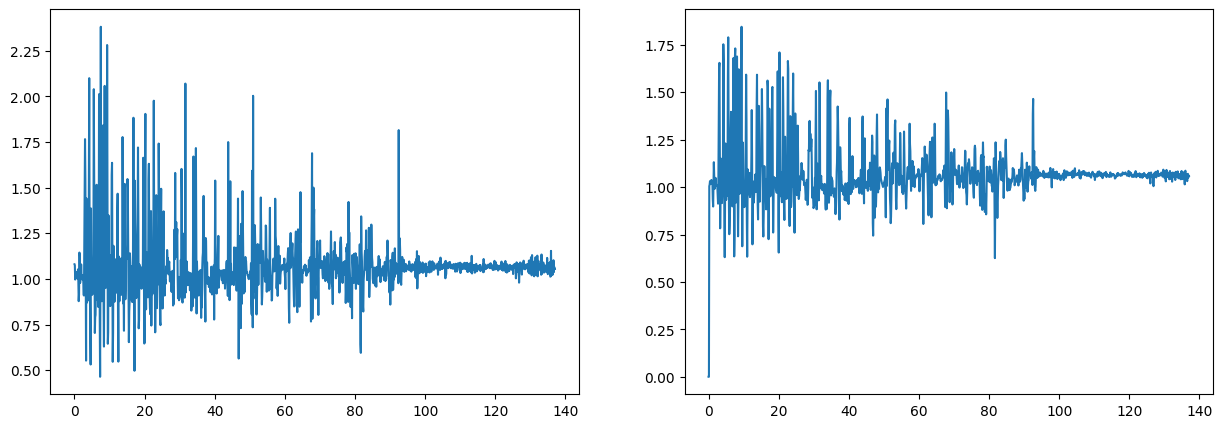

In [32]:
# let y be the low-pass filtered signal
y = applyFilter(x,b,a)
# compute the Fourier transform --> transform to frequency domain
yhat = np.fft.fft(y)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, x) # Filter zeroes out first two values
ax[1].plot(t, y)

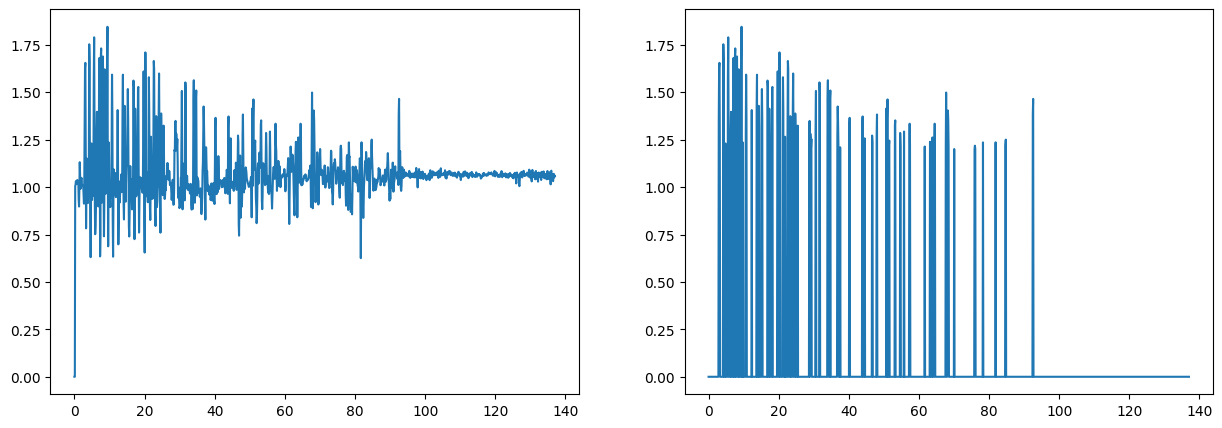

In [34]:
threshold_for_pushing = 1.20

threshold_signal = []

for i in y:
  if i >= threshold_for_pushing:
    threshold_signal.append(i)
  else:
    threshold_signal.append(0)
    
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, y) # Filter zeroes out first two values
ax[1].plot(t, threshold_signal)

In [35]:
movements = 0
currently_moving = False

for i in threshold_signal: # if i > 0 and not currently_pushing:
  if i > 0:
    movements += 1
    #currently_pushing = True
  #elif i == 0:
    #currently_pushing

print(movements)


128


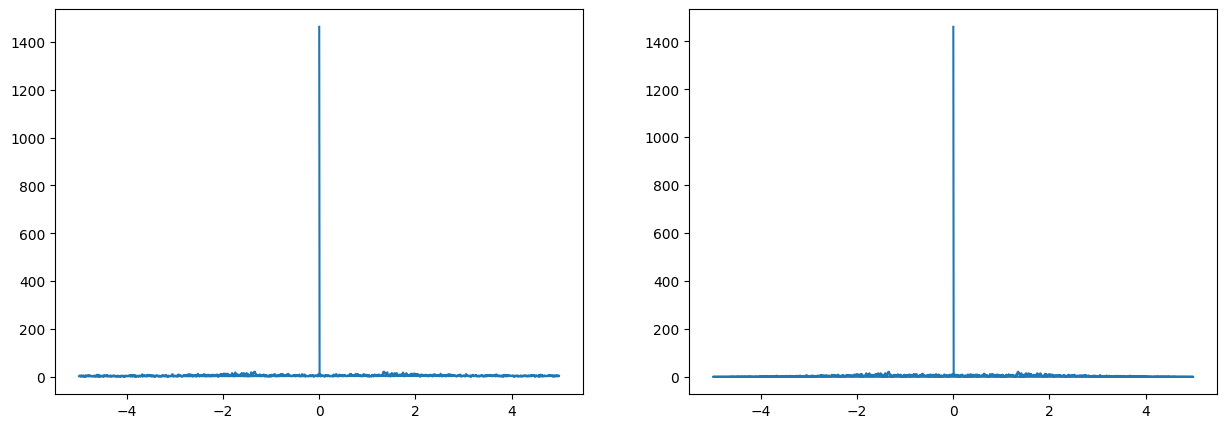

In [36]:
fcycles = np.fft.fftfreq(len(t),d=1.0/Fs); # the frequencies in cycles/s

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(fcycles,np.absolute(xhat))
ax[1].plot(fcycles,np.absolute(yhat))

In [47]:
# testing hpf
Fc = 25
a,b = hpfParams(Fc,Fs) 
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

Filter coefficients b_i: [ 0.11294354 -0.11294354]
Filter coefficients a_i: [-0.77411293]


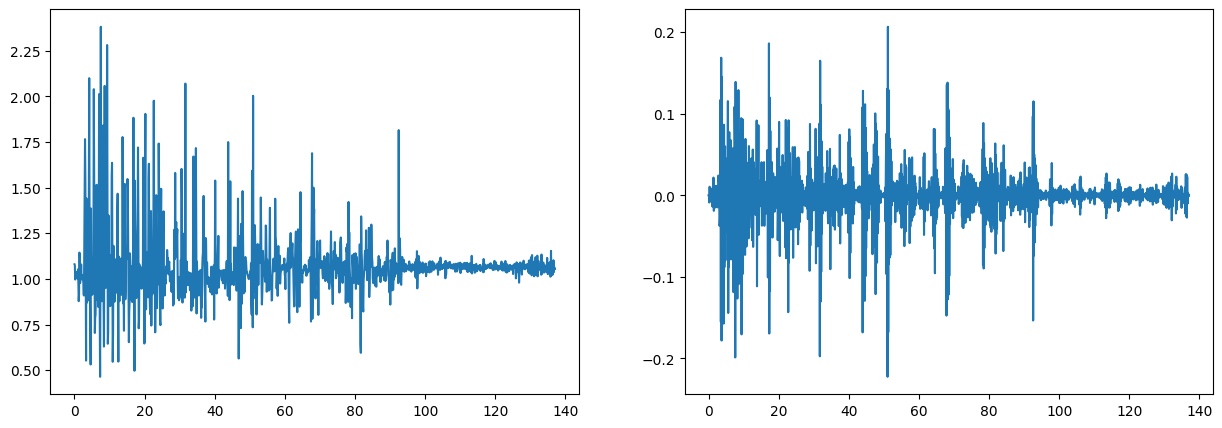

In [48]:
# let y now be the high-pass filtered signal
y = applyFilter(x,b,a)
# compute the Fourier transform --> transform to frequency domain
yhat = np.fft.fft(y)


fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, x)
ax[1].plot(t, y)

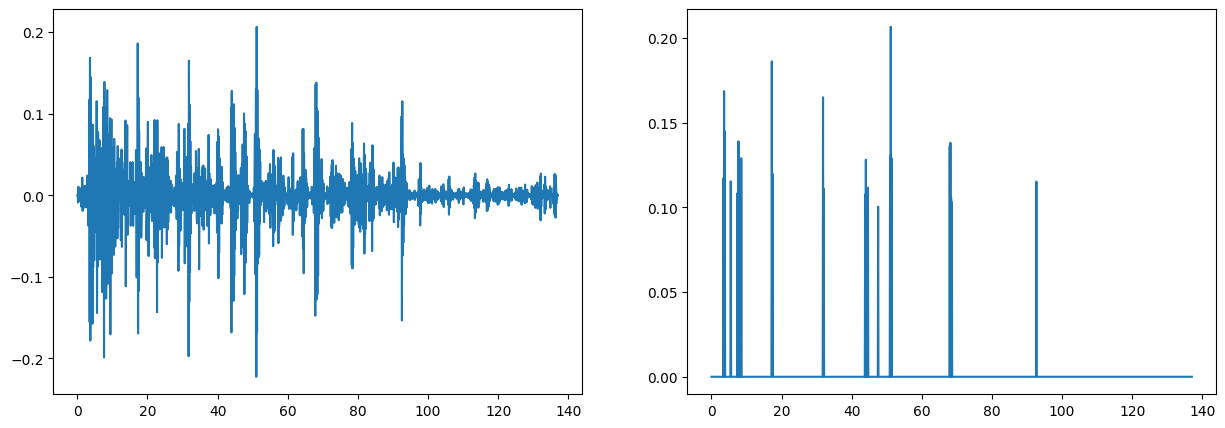

In [49]:
threshold_for_pushing = 0.1

threshold_signal_pushing = []

for i in y:
  if i >= threshold_for_pushing:
    threshold_signal_pushing.append(i)
  else:
    threshold_signal_pushing.append(0)
    
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, y) # Filter zeroes out first two values
ax[1].plot(t, threshold_signal_pushing)

In [50]:
pushes = 0
currently_pushing = False

for i in threshold_signal_pushing: # if i > 0 and not currently_pushing:
  if i > 0:
    pushes += 1
    #currently_pushing = True
  #elif i == 0:
    #currently_pushing

print(pushes)


24


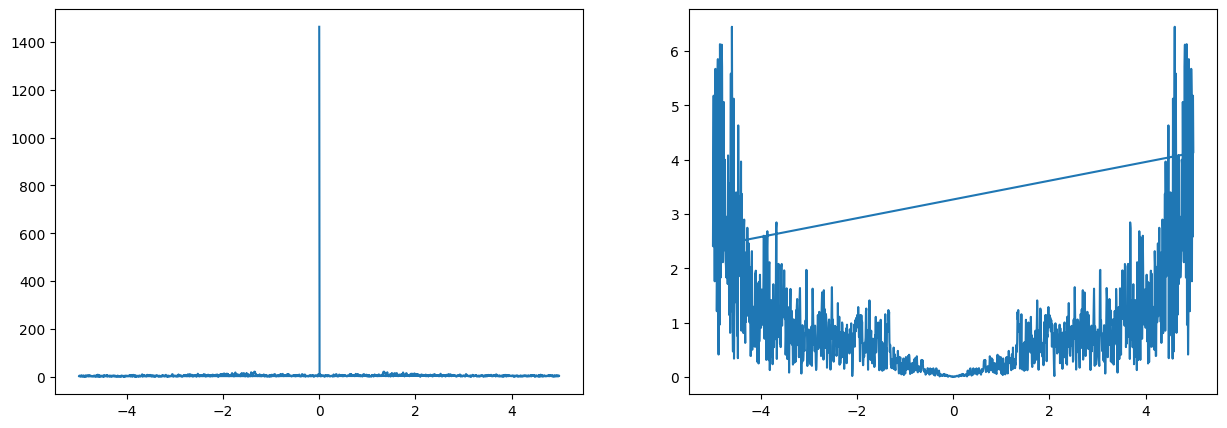

In [51]:
fcycles = np.fft.fftfreq(len(t),d=1.0/Fs); # the frequencies in cycles/s

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(fcycles,np.absolute(xhat))
ax[1].plot(fcycles,np.absolute(yhat))